In [134]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [135]:
WIG20 = ["ACP", "ALE", "CCC", "CDR", "CPS", "DNP", "JSW", "KGH", "KRU", "KTY", "LPP", "MBK", "OPL", "PCO", "PEO", "PGE", "PKN", "PKO", "PZU", "SPL"]

dfs = []

for company in WIG20:
    ticker = yf.Ticker(company + ".WA")
    dfs.append(ticker.history(period="1y"))

for df in dfs:
    print(df.size)

1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771
1771


In [136]:
dataset = []

for df in dfs:
    df_curr = df[["Close", "Volume"]]

    mean_close = df_curr["Close"].mean()
    mean_volume = df_curr["Volume"].mean()

    std_close = df_curr["Close"].std()
    std_volume = df_curr["Volume"].std()

    df_curr["Close"] = (df_curr["Close"] - mean_close) / std_close
    df_curr["Volume"] = (df_curr["Volume"] - mean_volume) / std_volume

    dataset.append(df_curr.to_numpy())

/tmp/ipykernel_2699/3181072393.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curr["Close"] = (df_curr["Close"] - mean_close) / std_close
/tmp/ipykernel_2699/3181072393.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_curr["Volume"] = (df_curr["Volume"] - mean_volume) / std_volume
/tmp/ipykernel_2699/3181072393.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [137]:
dataset

[array([[ 1.44593121e+00,  1.93744137e+00],
        [ 1.01879300e+00, -2.32582398e-02],
        [ 1.01879300e+00, -6.97787362e-01],
        [ 1.18307592e+00,  1.08618017e+00],
        [ 1.01879300e+00,  3.48925897e-01],
        [ 8.87364039e-01,  1.78200269e-02],
        [ 1.08450354e+00,  3.58692603e-02],
        [ 1.15021933e+00,  1.07737914e+00],
        [ 6.57367953e-01, -3.79019200e-01],
        [ 5.25941618e-01, -4.42008586e-01],
        [ 1.97373155e-01,  4.20350454e-01],
        [-1.64260341e+00,  4.26715431e+00],
        [-5.25474314e-01,  1.46618971e+00],
        [-7.88329609e-01,  1.42208291e+00],
        [-1.06761057e+00,  5.02446010e-01],
        [-9.52612528e-01, -1.00313019e-01],
        [-9.52612528e-01,  6.91271887e-01],
        [-1.42903562e+00,  2.45264759e-01],
        [-1.59331854e+00,  9.58148503e-01],
        [-1.92188700e+00, -5.62133552e-01],
        [-1.47623601e-01,  3.08213493e-01],
        [-9.69040820e-01, -5.32498662e-01],
        [ 4.95185278e-02,  6.481

In [138]:
train_epochs, test_epochs = [], []

for epoch in dataset:
    train, test = np.array_split(epoch, 2)
    
    train_epochs.append(train)
    test_epochs.append(test)

print(train_epochs[0][0], type(train_epochs[0][0]))

[1.44593121 1.93744137] <class 'numpy.ndarray'>


In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

n = 16
m = 32

model = nn.Sequential(
    nn.Linear(n, m),
    nn.GELU(),
    nn.Linear(m, n),
    nn.GELU(),
    nn.Linear(n, 2),
)

print(model)

optimizer = optim.AdamW(model.parameters())
loss_function = nn.MSELoss()

Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): GELU(approximate=none)
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): GELU(approximate=none)
  (4): Linear(in_features=16, out_features=2, bias=True)
)


In [140]:
class Iter:
    def __init__(self, vals) -> None:
        self.data = vals.flatten()
        self.idx = 0

    def __next__(self):
        if self.data.size - 1 > self.idx + 18:
            self.idx += 2

            return torch.tensor(self.data[self.idx:self.idx + 16]).to(torch.float), torch.tensor(self.data[self.idx + 17: self.idx + 18]).to(torch.float).squeeze()
        else:
            raise StopIteration

    def __iter__(self):
        return self


In [141]:
train_loss_before, test_loss_before = [], []

for train in train_epochs:
    trx = Iter(train)

    for x, y in trx:
        y_hat = model(x)
        loss = loss_function(y_hat, y)
        
        train_loss_before.append(float(loss))

for test in test_epochs:
    flat = test.flatten()

    for offset in range(0, flat.size // 2, 2):
        loss = loss_function(model(torch.tensor(flat[offset: offset + 16]).to(torch.float)), torch.tensor(flat[offset + 16: offset + 18]).to(torch.float))
        test_loss_before.append(float(loss))


print("Train loss before: ", sum(train_loss_before) / len(train_loss_before))
print("Test loss before: ", sum(test_loss_before) / len(test_loss_before))


/home/mputo/.conda/envs/trading/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss before:  1.0662622595901465
Test loss before:  1.0210961996383423


In [142]:
loss_history = []

for epoch in train_epochs:
    trx = Iter(epoch)

    for x, y in trx:
        optimizer.zero_grad()

        y_hat = model(x)
        loss = loss_function(y_hat, y)

        loss.backward()
        optimizer.step()

        loss_history.append(float(loss))
        print(loss)

tensor(0.0944, grad_fn=<MseLossBackward0>)
tensor(0.3040, grad_fn=<MseLossBackward0>)
tensor(19.3141, grad_fn=<MseLossBackward0>)
tensor(2.4034, grad_fn=<MseLossBackward0>)
tensor(2.3694, grad_fn=<MseLossBackward0>)
tensor(0.3378, grad_fn=<MseLossBackward0>)
tensor(0.0040, grad_fn=<MseLossBackward0>)
tensor(0.5415, grad_fn=<MseLossBackward0>)
tensor(0.0584, grad_fn=<MseLossBackward0>)
tensor(0.9090, grad_fn=<MseLossBackward0>)
tensor(0.4754, grad_fn=<MseLossBackward0>)
tensor(0.0750, grad_fn=<MseLossBackward0>)
tensor(0.2651, grad_fn=<MseLossBackward0>)
tensor(0.0156, grad_fn=<MseLossBackward0>)
tensor(0.1413, grad_fn=<MseLossBackward0>)
tensor(0.2056, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.7658, grad_fn=<MseLossBackward0>)
tensor(5.6044, grad_fn=<MseLossBackward0>)
tensor(0.7288, grad_fn=<MseLossBackward0>)
tensor(0.0195, grad_fn=<MseLossBackward0>)
tensor(0.1658, grad_fn=<MseLossBackward0>)
tensor(3.9057, grad_fn=<MseLossBackward0>)
tensor(0.1

Train loss: 0.8293081816104124


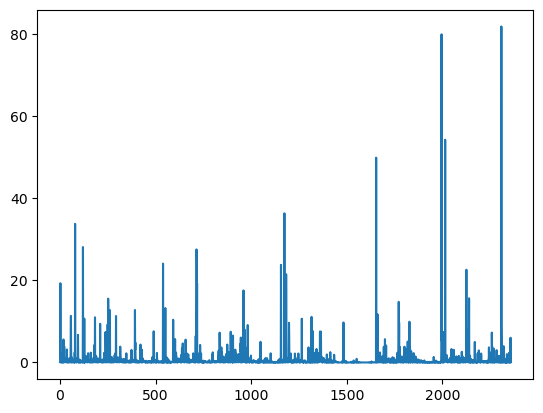

In [143]:
print("Train loss:", sum(loss_history) / len(loss_history))

plt.plot(loss_history)

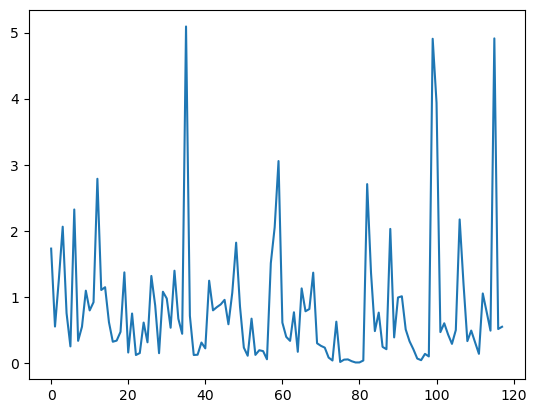

In [144]:
grouped = np.array(loss_history).reshape(-1, 20)

loss_avg = []
for group in grouped:
    loss_avg.append(group.mean())

plt.plot(loss_avg)

Test loss: 0.9827431319558638


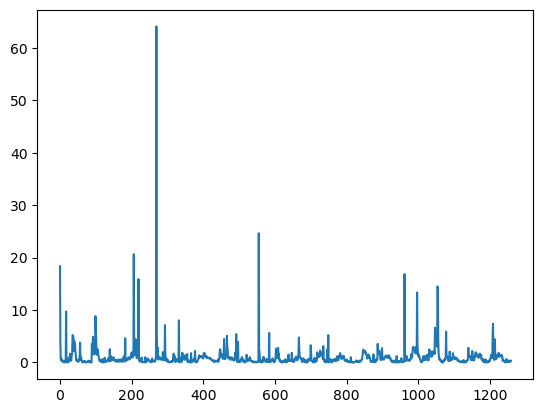

In [145]:
loss_test = []

for test in test_epochs:
    flat = test.flatten()

    for offset in range(0, flat.size // 2, 2):
        loss = loss_function(model(torch.tensor(flat[offset: offset + 16]).to(torch.float)), torch.tensor(flat[offset + 16: offset + 18]).to(torch.float))
        loss_test.append(float(loss))

print("Test loss:", sum(loss_test) / len(loss_test))

plt.plot(loss_test)

Linear(in_features=16, out_features=32, bias=True)


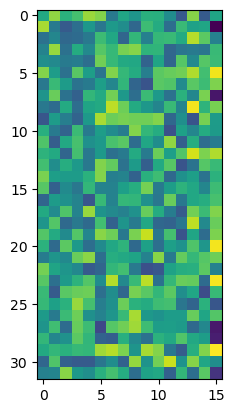

In [146]:
params = model[0].parameters()

print(model[0])

plt.imshow(next(params).detach().numpy())

[1.0555438309307739, 0.8698877963733276, 1.0, 1.192465078222491, 1.0, 1.2769291484151015, 0.9659875460016342, 0.99945178752023, 1.0858941665481965, 1.153873335798934, 0.9795510913150709, 1.1434923566675566, 1.03856867677798, 1.0153687803088296, 1.003345902025196, 0.9825297264060748, 1.009699865679891, 0.9973491235512721, 0.9975985326597078, 1.067651545114568]
Avg: 1.0417594145158415


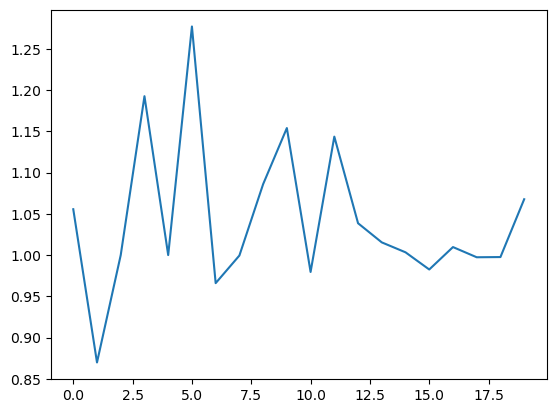

In [223]:
res = []
mean_changes = []

transaction_cost = 0.000

for df in dfs:
    mean_changes.append((df.diff().abs().mean() / df)["Close"].mean())

for i, test in enumerate(test_epochs):
    flat = test.flatten()

    cash = 1.0
    stock = 0.0
    predicted = 0

    for offset in range(0, flat.size // 2, 2):
        change = float(torch.tensor(flat[offset + 14]).to(torch.float))

        if stock > 0.0:
            stock += mean_changes[i] * change


        if change > predicted:
           if cash > 0:
                stock += (1 - transaction_cost) * cash
                cash = 0.0
        elif change < predicted:
            if stock > 0:
                cash += (1 - transaction_cost) * stock
                stock = 0.0

        predicted = model(torch.tensor(flat[offset: offset + 16]).to(torch.float))[0]

    cash += stock
    res.append(cash)

print(res)
print(f"Avg: {sum(res) / len(res)}")
plt.plot(res)

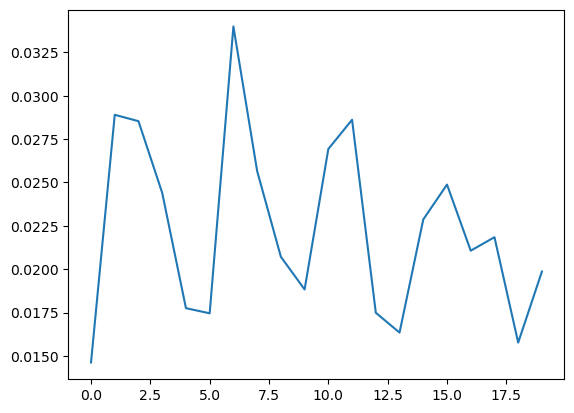

In [207]:
vs = []
for df in dfs:
    var = (df.diff().abs().mean() / df)["Close"].mean()
    vs.append(var)

plt.plot(vs)